# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from BCA import *
from general_utils import *
from visualization_utils import * 

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Nonnegative_Antisparse_Copula'

# Source Generation and Mixing Scenario

In [3]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10
S = generate_correlated_copula_sources(rho = 0.7, df = 4, n_sources = NumberofSources, 
                                       size_sources = N , decreasing_correlation = True)


print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.998630024736283


# Visualize Generated Sources and Mixtures

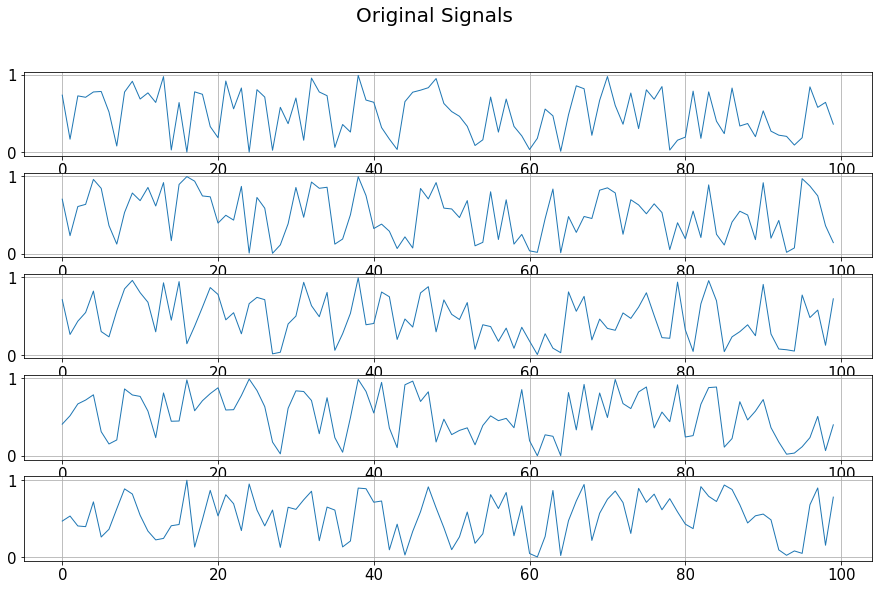

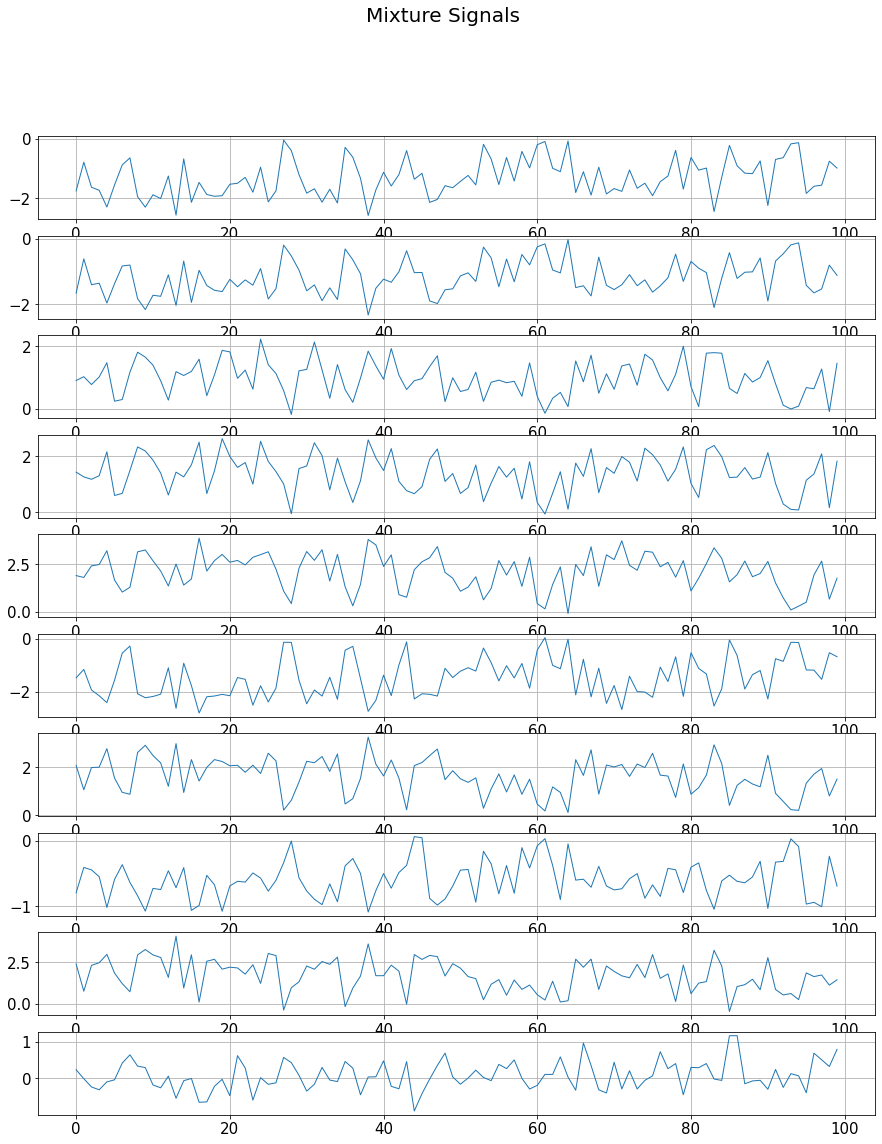

In [4]:
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X[:,0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
# HYPERPARAMETERS DEFINED IN THE PAPER
lambda_ = 0.99
mu_F = 1e-3
beta = 30
debug_iteration_point = 25000

model = OnlineBCA(s_dim = NumberofSources, x_dim = NumberofMixtures, 
                  lambda_ = lambda_, mu_F = mu_F, beta = beta, 
                  set_ground_truth = True, S = S, A = A)

# Run CorInfoMax Algorithm on Mixture Signals

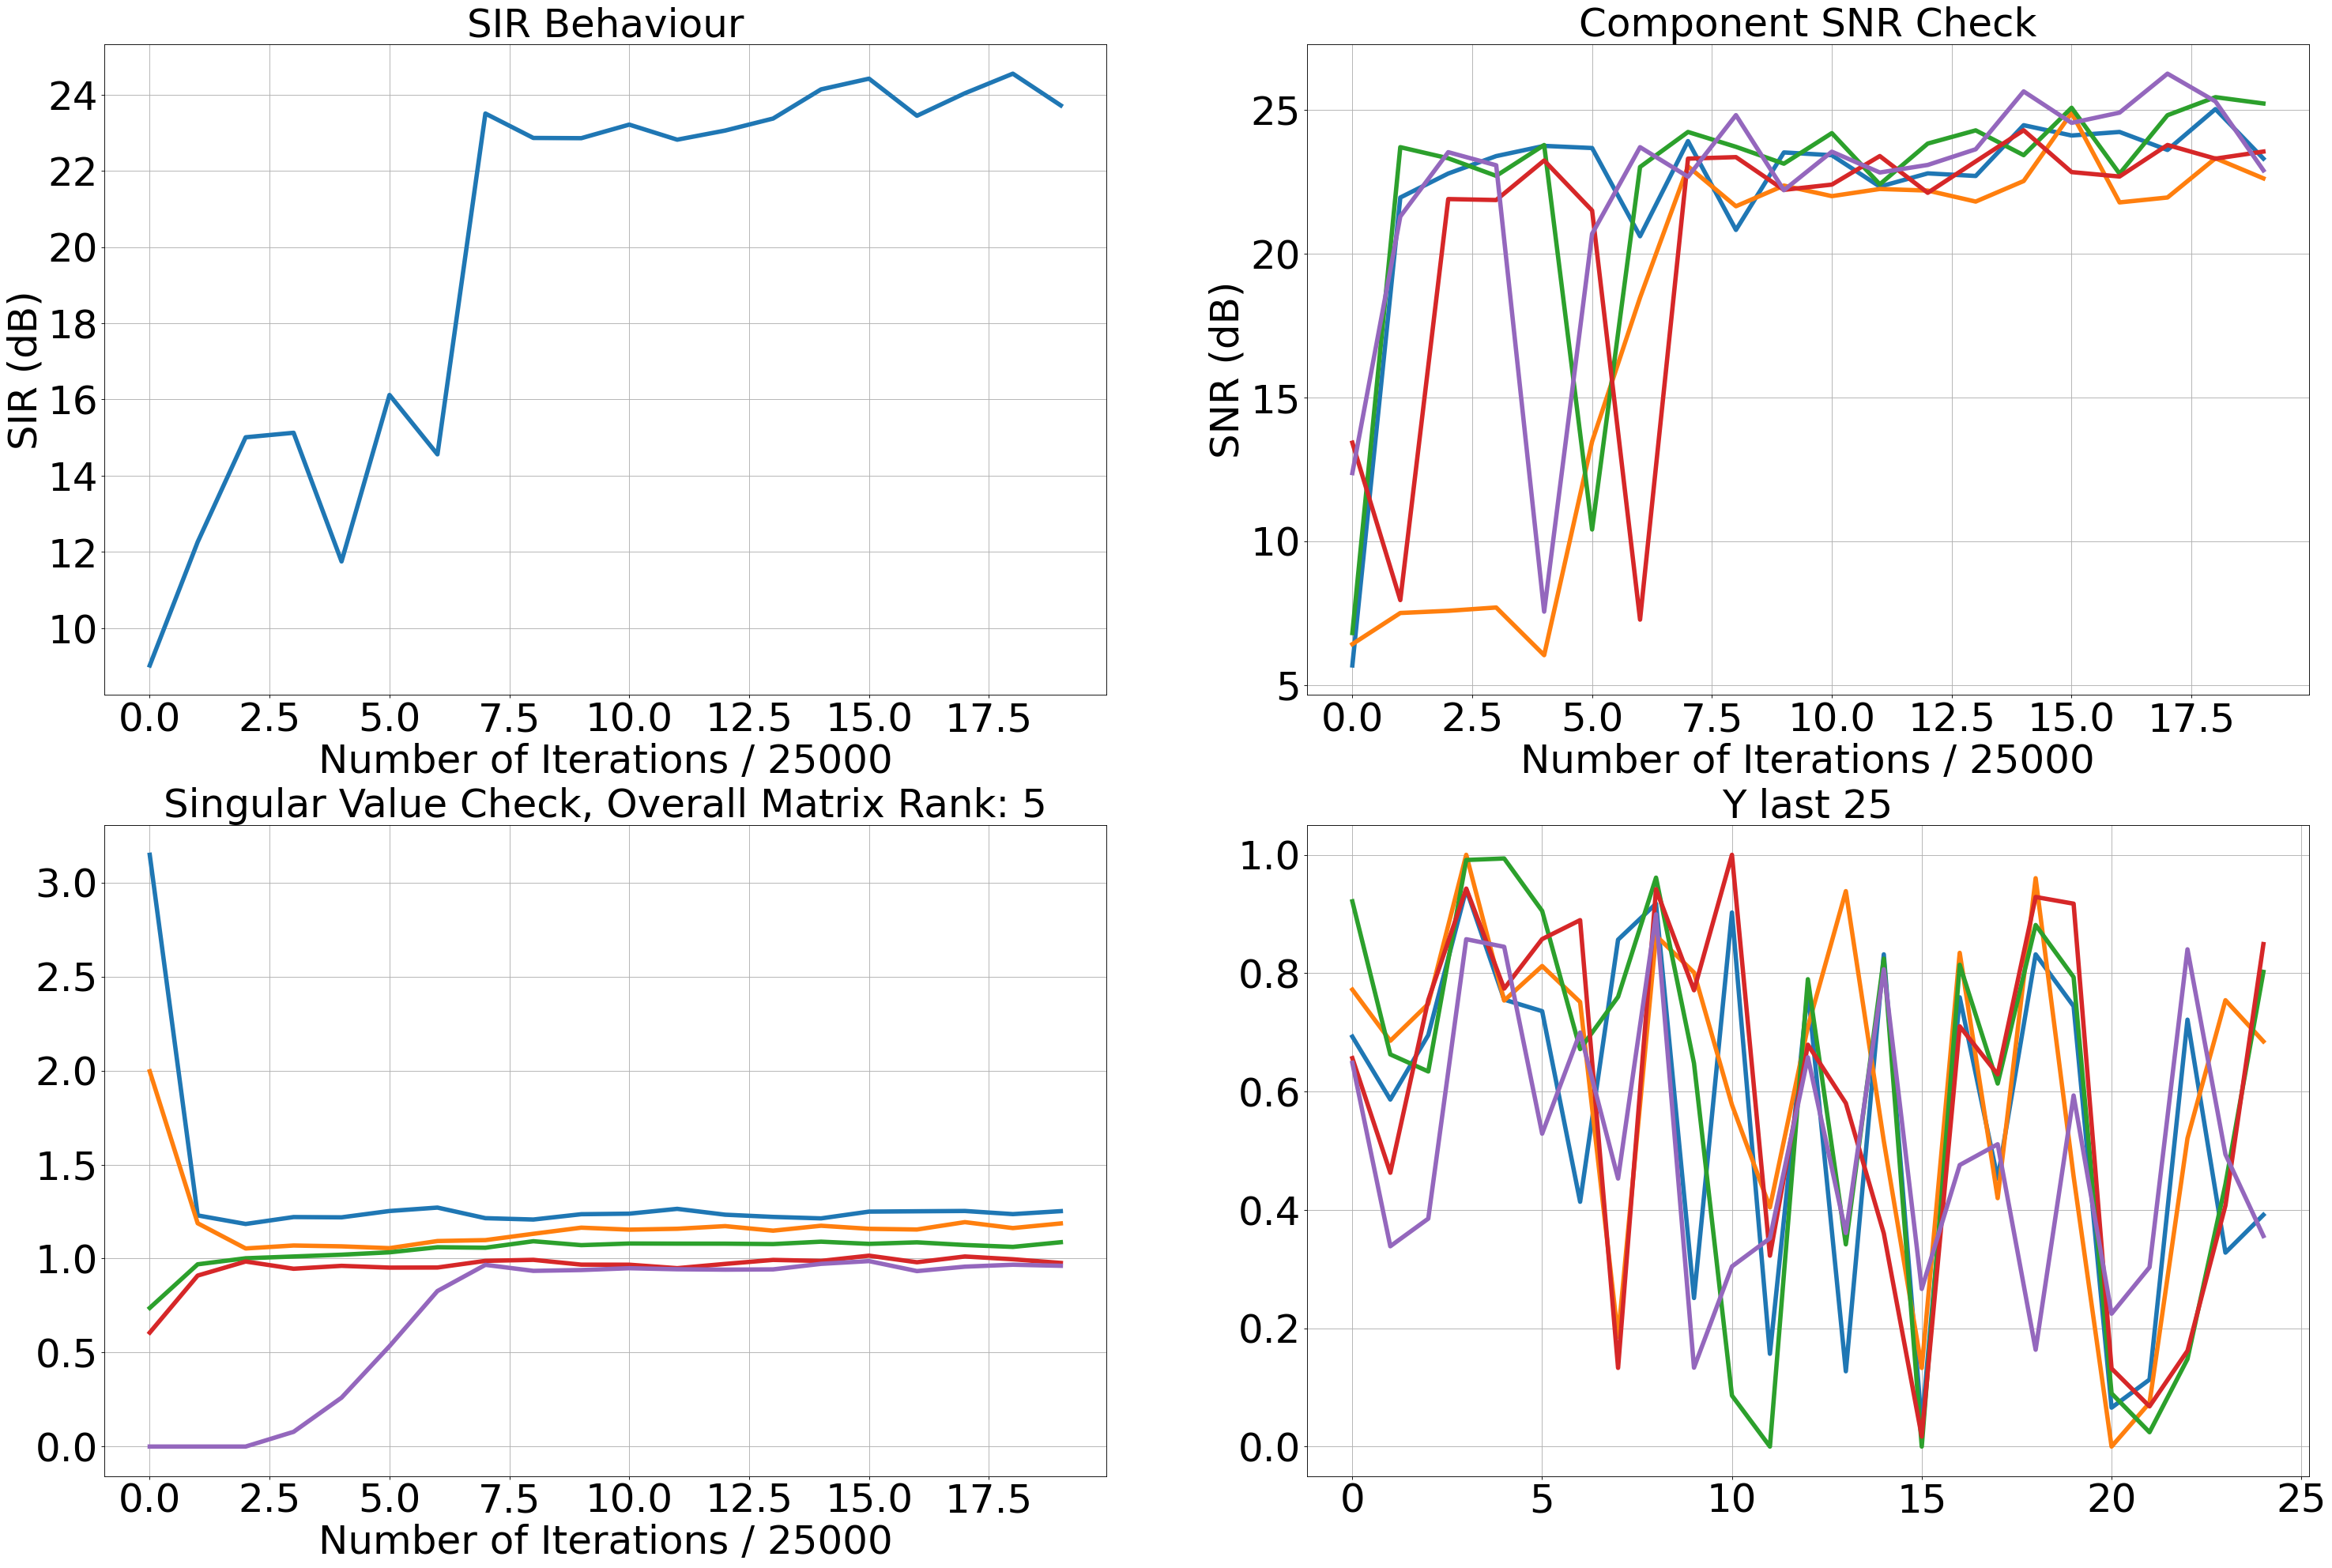

100%|██████████| 500000/500000 [01:46<00:00, 4689.43it/s] 


Algorithm took 106.835515 sec.


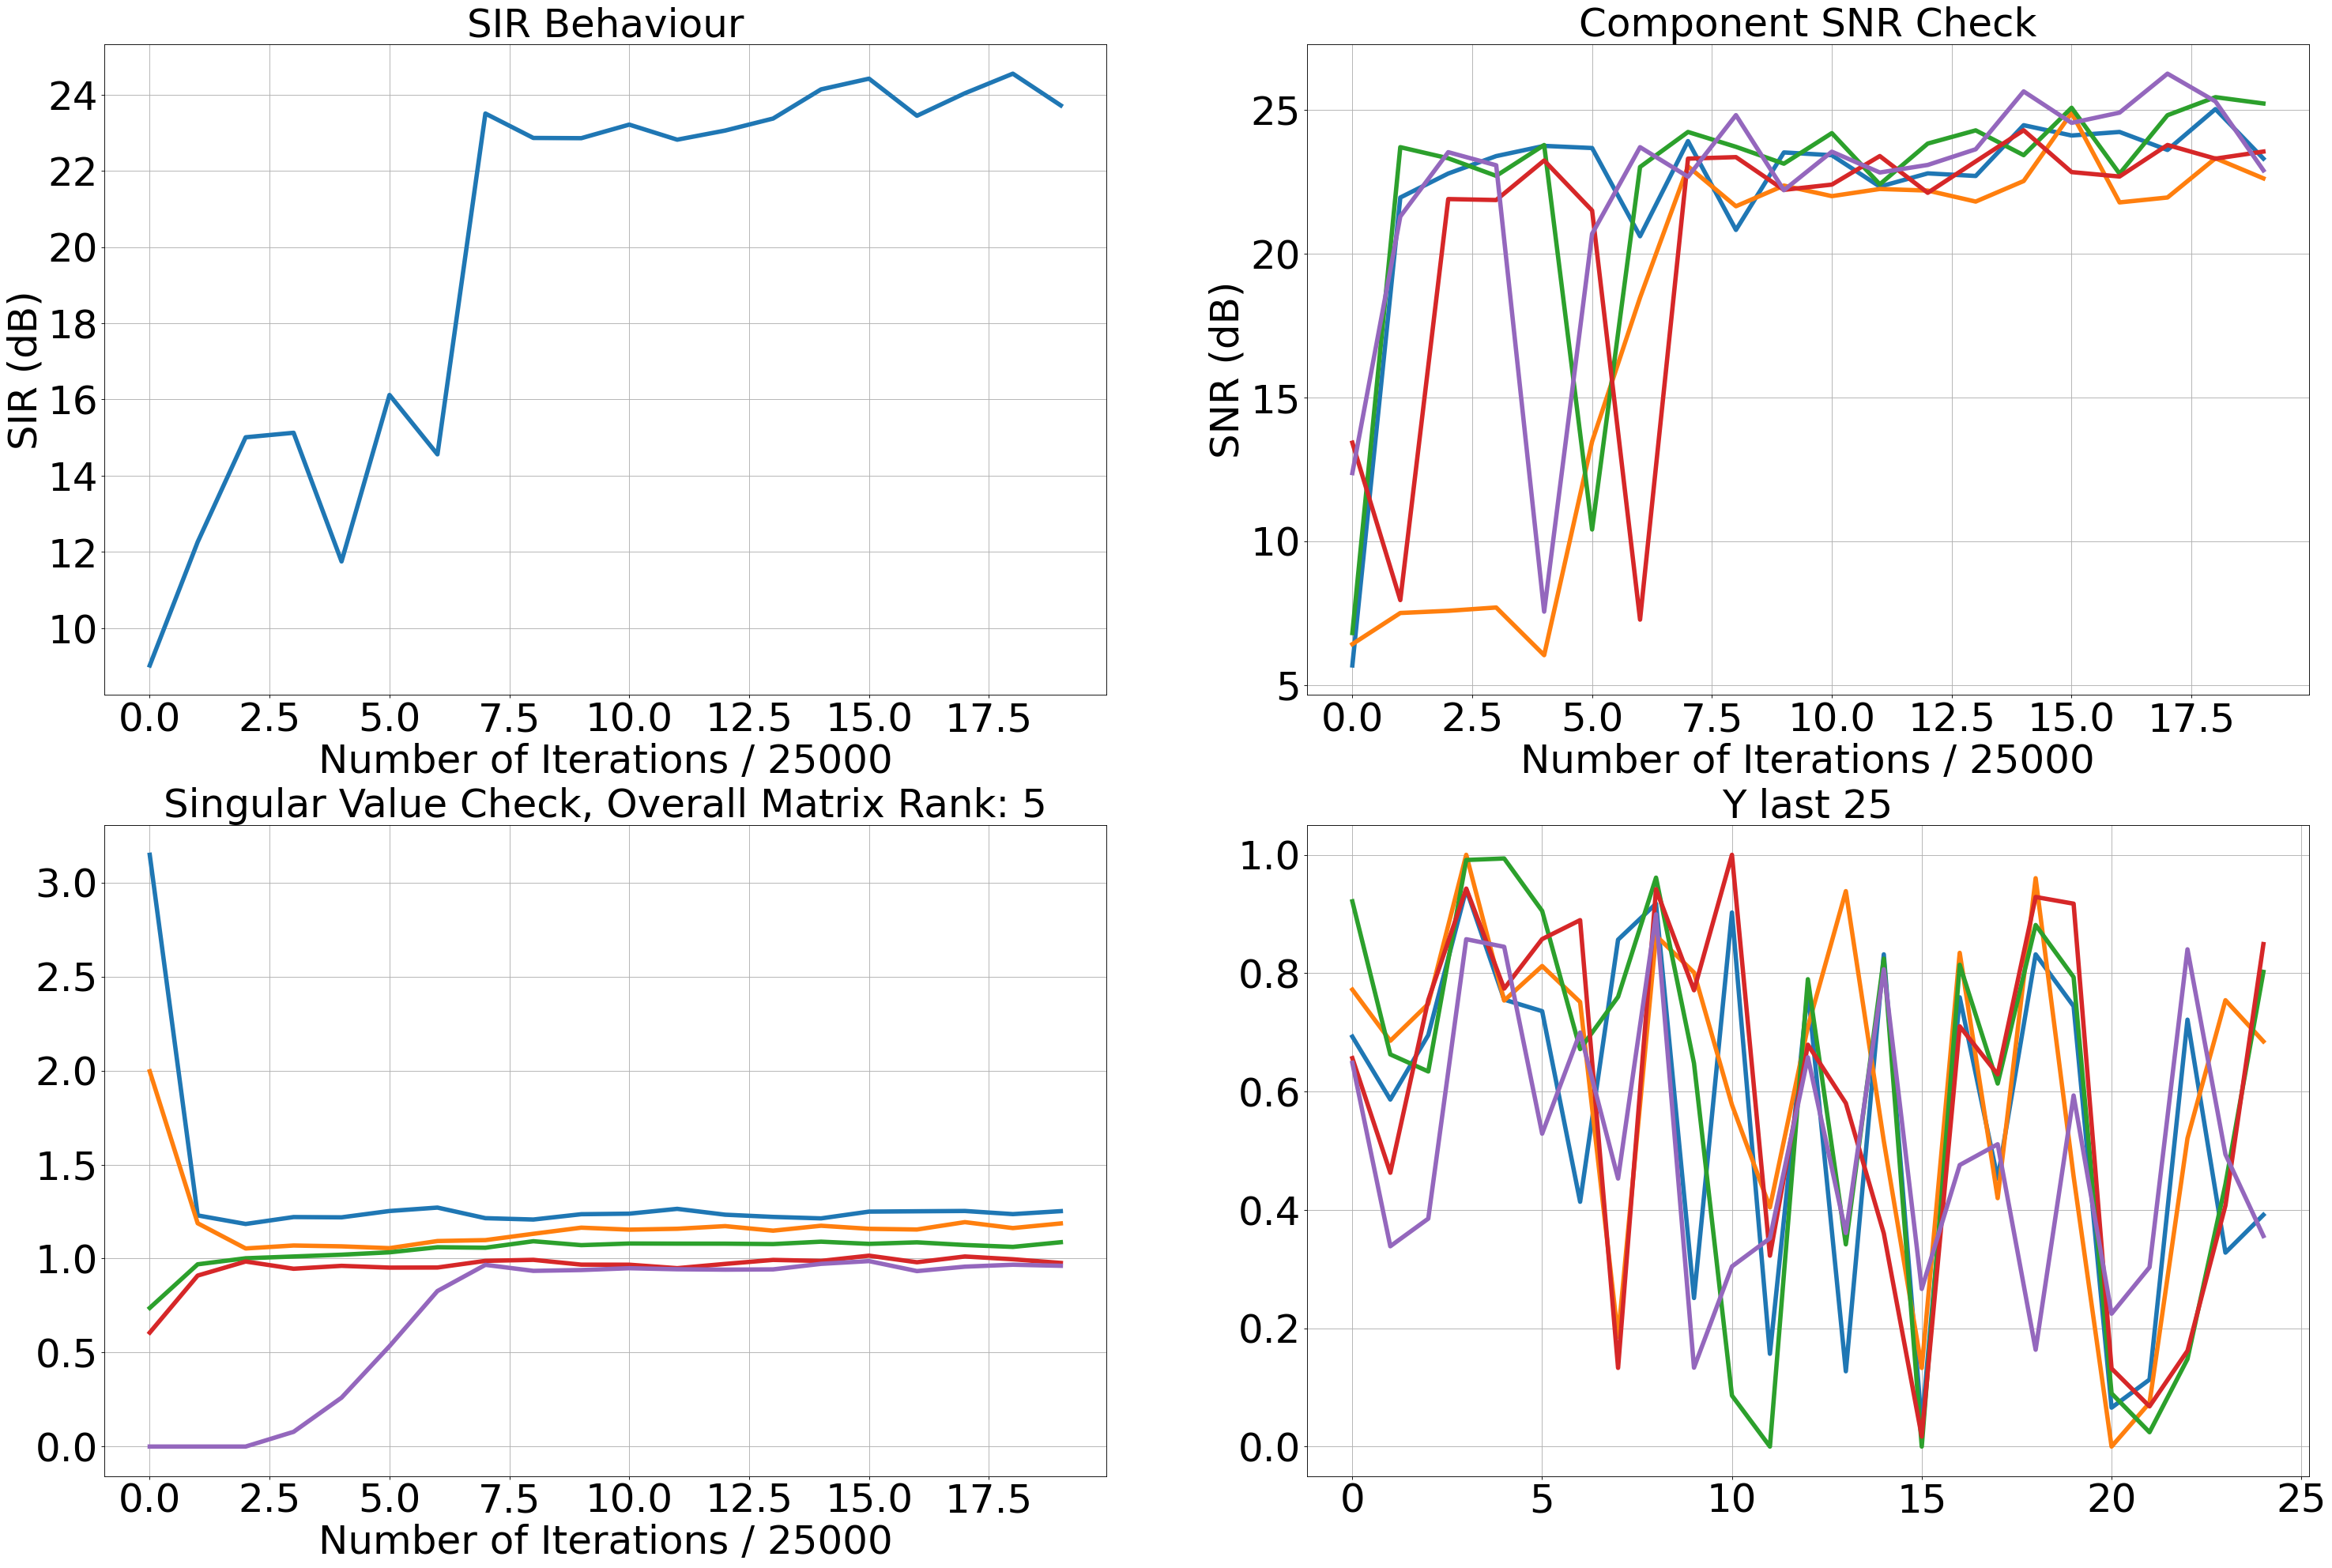

In [6]:
with Timer() as t:
    model.fit_batch_nnantisparse(X, n_epochs = 1, neural_lr_start = 0.9, 
                                 neural_dynamic_iterations = 500, 
                                 shuffle = False, 
                                 debug_iteration_point = debug_iteration_point,
                                 plot_in_jupyter = True)
print('Algorithm took %f sec.' % (t.interval))

# Visualize SINR Convergence 

Final SINR: 23.714217877618307


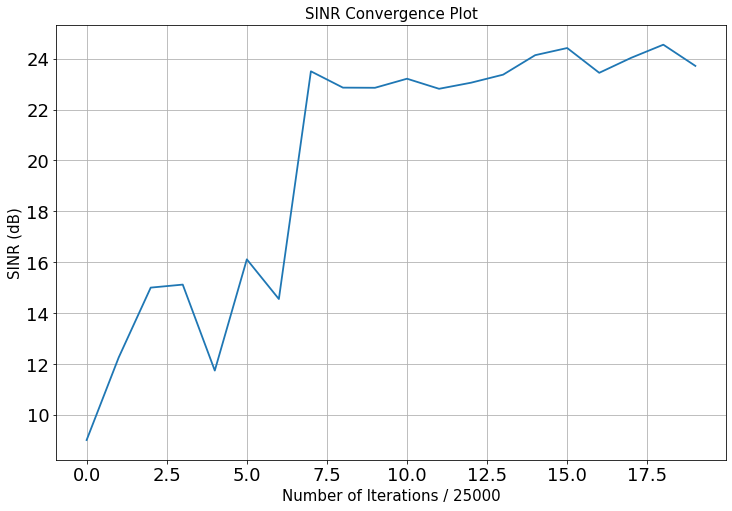

In [7]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SIR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

print('Final SINR: {}'.format(np.array(model.SIR_list[-1])))

# Calculate Resulting Component SNRs and Overall SINR

In [8]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINR = 10*np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [23.95470596 23.67188104 24.81931855 24.76014395 27.16336916]

Overall SINR : 24.870413304958273


# Vizualize Extracted Signals Compared to Original Sources

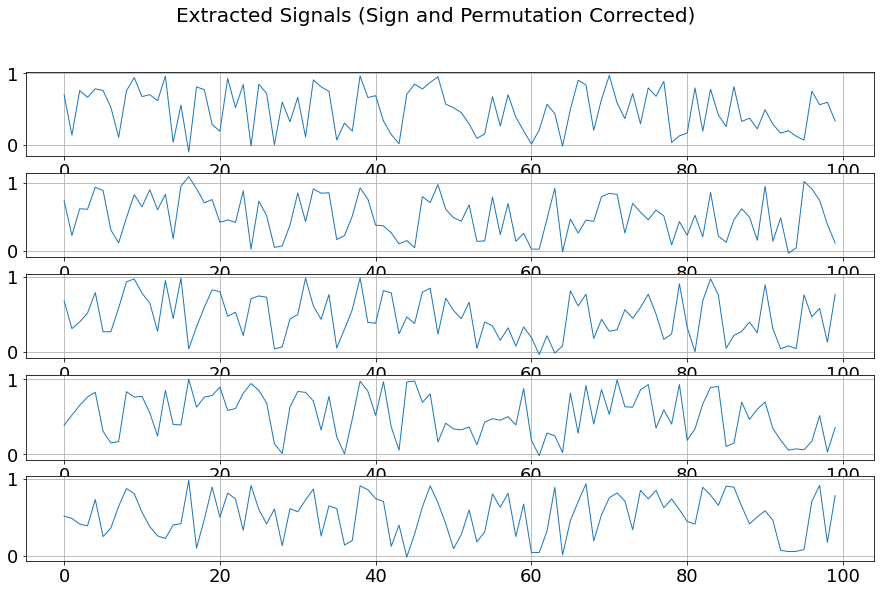

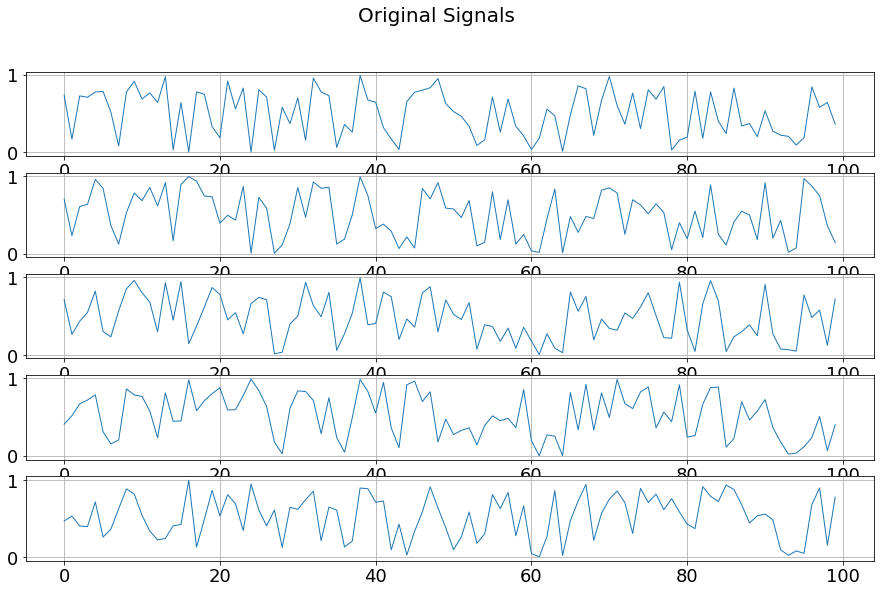

In [9]:
subplot_1D_signals(Y_[:,0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)